Data Exploring
Input file: Historical Product Demand.csv

Description: CSV data file containing product demand for encoded product id's

Size of Data: (1048575, 5)

Features: Product_Code, Warehouse, Product_Category, Date, Order_Demand

Period: 2011-01-08 ~ 2017-01-09


In [1]:
# DataFrame
import pandas as pd
import numpy as np
import random
from datetime import datetime, date

# Preprocessing
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import warnings
from pandas.errors import SettingWithCopyWarning
warnings.simplefilter(action='ignore', category=SettingWithCopyWarning)

# Save the log
import os

# EEMD
from PyEMD import EEMD

# LSTM
import tensorflow as tf

from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import SimpleRNN
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Activation

from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MSE

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Metric 
# Metric
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_log_error

In [2]:
df = pd.read_csv('PNS_0501.csv')
# convert the string to the datetype
df['거래명세서일'] = df['거래명세서일'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))
df

,거래명세서일,product,code_length,product_type,출고수량
0,2015-01-17,2KPKRI001,10.0,KP,20000.0
1,2015-01-18,2KPKRI001,NaN,KP,0.0
2,2015-01-19,2KPKRI001,NaN,KP,0.0
3,2015-01-20,2KPKRI001,NaN,KP,0.0
4,2015-01-21,2KPKRI001,NaN,KP,0.0
...,...,...,...,...,...
23667,2023-03-25,2SWSIP002,NaN,SW,0.0
23668,2023-03-26,2SWSIP002,NaN,SW,0.0
23669,2023-03-27,2SWSIP002,NaN,SW,0.0
23670,2023-03-28,2SWSIP002,NaN,SW,0.0


In [3]:
print(df.info())
print('-------------------------')
print("")
print("The Number of unique")
print('-------------------------')
print('Product code:\t', df['product'].nunique())
print('Category:\t', df.product_type.nunique())
print('-------------------------')
print("The Product Code:")
print("")
for i, code in enumerate(df['product'].unique()):
    print(i+1, code)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23672 entries, 0 to 23671
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   거래명세서일        23672 non-null  datetime64[ns]
 1   product       23672 non-null  object        
 2   code_length   4346 non-null   float64       
 3   product_type  23672 non-null  object        
 4   출고수량          23672 non-null  float64       
dtypes: datetime64[ns](1), float64(2), object(2)
memory usage: 924.8+ KB
None
-------------------------

The Number of unique
-------------------------
Product code:	 8
Category:	 4
-------------------------
The Product Code:

1 2KPKRI001
2 2KVLTJ003
3 2LMSIP002
4 2SWKHC003
5 2SWKHC005
6 2SWKHC007
7 2SWLGC019
8 2SWSIP002


In [19]:
k = df['product'] =='2SWKHC005'
y_1248 = df[k]
#y_1248 = y_1248.set_index('거래명세서일')
#y_0016 = y_0016['Product_Code']=='Product_0016'
y_hat1248 = y_1248['출고수량']

In [20]:
y_1248

,거래명세서일,product,code_length,product_type,출고수량
11932,2015-01-31,2SWKHC005,10.0,SW,68000.0
11933,2015-02-01,2SWKHC005,NaN,SW,0.0
11934,2015-02-02,2SWKHC005,NaN,SW,0.0
11935,2015-02-03,2SWKHC005,10.0,SW,12000.0
11936,2015-02-04,2SWKHC005,NaN,SW,0.0
...,...,...,...,...,...
14901,2023-03-19,2SWKHC005,NaN,SW,0.0
14902,2023-03-20,2SWKHC005,10.0,SW,16000.0
14903,2023-03-21,2SWKHC005,NaN,SW,0.0
14904,2023-03-22,2SWKHC005,NaN,SW,0.0


In [21]:
y_hat1248

11932    68000.0
11933        0.0
11934        0.0
11935    12000.0
11936        0.0
          ...   
14901        0.0
14902    16000.0
14903        0.0
14904        0.0
14905     8000.0
Name: 출고수량, Length: 2974, dtype: float64

Time Series Graph

Decomposition  
Additive model : y(t) = Trend + Seasonality + Noise


In [22]:
def ts_train_val_test(eIMF_df, time_steps): 

    ts_train_end = len(eIMF_df[eIMF_df['거래명세서일']<'2022-04-01']) # train 데이터 종료 인덱스
    ts_val_end = len(eIMF_df[eIMF_df['거래명세서일']<'2022-10-01']) # validation 데이터 종료 인덱스
    ts = eIMF_df.filter(['출고수량']).values # y(수요량) 값
    
    # Minmax로 0~1 사이에 값이 오도록 정규화
    sc = MinMaxScaler() # 객체 생성
    ts_scaled = sc.fit_transform(ts) # 전체 y값 정규화
    
    # Train Data
    ts_train_scaled = ts_scaled[:ts_train_end,:]

    X_train = [] 
    y_train = []
    for i in range(time_steps, ts_train_end): 
        X_train.append(ts_train_scaled[i-time_steps:i,0]) # time steps 만큼 sliding window
        y_train.append(ts_train_scaled[i,0])

    X_train = np.array(X_train)
    y_train = np.array(y_train)
    
    # Reshape X_train for LSTM -> (batch_size, time_steps, features)
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1],1))

    # Validation Data
    ts_val_scaled = ts_scaled[ts_train_end : ts_val_end, :]

    X_val = []
    y_val = []
    for i in range(time_steps, len(ts_val_scaled)):
        X_val.append(ts_val_scaled[i-time_steps : i, 0])
        y_val.append(ts_val_scaled[i, 0])

    X_val = np.array(X_val)
    y_val = np.array(y_val)

    # Reshape X_val for LSTM -> (batch_size, time_steps, features)
    X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1],1))
    
 
    # Test Data
    ts_test_scaled = ts_scaled[ts_val_end - time_steps:,:]

    X_test = []
    y_test = eIMF_df.iloc[ts_val_end:,:]

    for i in range(time_steps, len(ts_test_scaled)):
        X_test.append(ts_test_scaled[i-time_steps : i, 0])
    
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1],1))
    
    return X_train, y_train, X_val, y_val, X_test, y_test, sc

In [23]:
def LSTM_model(X_train, y_train, X_val, y_val, X_test, sc, epochs=20):
    # LSTM 모델 객체 생성
    my_LSTM_model = Sequential() 
    
    # 첫 번째 LSTM 레이어 구성
    # 활성화 함수는 ReLU를 사용하며, return_sequences=True로 지정하여 다음 LSTM 레이어의 입력으로 사용할 수 있도록 함
    my_LSTM_model.add(LSTM(512, activation='relu',return_sequences=True, input_shape=(X_train.shape[1],1)))
    
    # 두 번째 LSTM 레이어 구성
    # 활성화 함수는 ReLU를 사용하며, return_sequences=False로 지정하여 마지막 LSTM 레이어임을 나타냄
    my_LSTM_model.add(LSTM(256, activation = 'relu',return_sequences=False))
    
    # Fully connected 레이어들 추가
    # 마지막 레이어에서는 출력의 unit 개수를 1로 설정하여 1개의 값을 출력
    my_LSTM_model.add(Dense(128))
    my_LSTM_model.add(Dense(64))
    my_LSTM_model.add(Dense(32))
    my_LSTM_model.add(Dense(1))
    
    # 모델 컴파일
    my_LSTM_model.compile(optimizer = "Adam", # Adam optimizer 사용
                         loss = 'mean_squared_error', # 손실 함수로는 평균 제곱 오차 사용
                          metrics=['mape','mae']) # 성능 지표로는 MAPE와 MAE를 사용
    #조기종료 조건
    #early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    # 모델 Fitting
    my_LSTM_model.fit(X_train, # 입력 데이터
                      y_train, # 출력 데이터
                      epochs = epochs, # epoch 수
                      batch_size = 16, # batch size
                      validation_data=(X_val, y_val),
                      #callbacks=[early_stopping],# validation에 따른 조기종료
                      verbose = 1) # 학습 상태를 출력
    
    # Test 데이터 예측
    LSTM_prediction = my_LSTM_model.predict(X_test) # 예측값 얻기
    LSTM_prediction_normalized = LSTM_prediction # 예측값을 저장하되, normalize된 값 저장
    LSTM_prediction = sc.inverse_transform(LSTM_prediction) # denormalize된 예측값 저장
    
    # 모델 객체와 예측값 반환
    return my_LSTM_model, LSTM_prediction, LSTM_prediction_normalized

In [24]:
def actual_pred_plot(all_data,predictions):
    """
    Plot the actual vs predition
    """
    orderD = all_data.filter(['출고수량'])
    orderD["Predictions"] = predictions
    #visualize the data
    plt.figure(figsize=(16, 8))
    plt.title("Forecast with Optimized LSTM Model")
    plt.xlabel("Time", fontsize=14)
    plt.ylabel("Order Demand", fontsize=14)
    plt.plot(all_data["거래명세서일"], orderD[["출고수량", "Predictions"]])#varies
    plt.legend([ "Actual", "Predictions"], loc="upper right")
    plt.show()

Epoch 1/20
162/162 [==============================] - 46s 270ms/step - loss: 0.0081 - mape: 33547802.0000 - mae: 0.0675 - val_loss: 0.0136 - val_mape: 28521234.0000 - val_mae: 0.0800
Epoch 2/20
162/162 [==============================] - 41s 255ms/step - loss: 0.0080 - mape: 33849368.0000 - mae: 0.0680 - val_loss: 0.0132 - val_mape: 36966432.0000 - val_mae: 0.0853
Epoch 3/20
162/162 [==============================] - 38s 236ms/step - loss: 0.0080 - mape: 33871844.0000 - mae: 0.0679 - val_loss: 0.0132 - val_mape: 38131988.0000 - val_mae: 0.0861
Epoch 4/20
162/162 [==============================] - 41s 252ms/step - loss: 0.0081 - mape: 34019624.0000 - mae: 0.0680 - val_loss: 0.0131 - val_mape: 41547200.0000 - val_mae: 0.0882
Epoch 5/20
162/162 [==============================] - 39s 242ms/step - loss: 0.0080 - mape: 34238848.0000 - mae: 0.0682 - val_loss: 0.0136 - val_mape: 28455638.0000 - val_mae: 0.0799
Epoch 6/20
162/162 [==============================] - 38s 237ms/step - loss: 0.0080 -

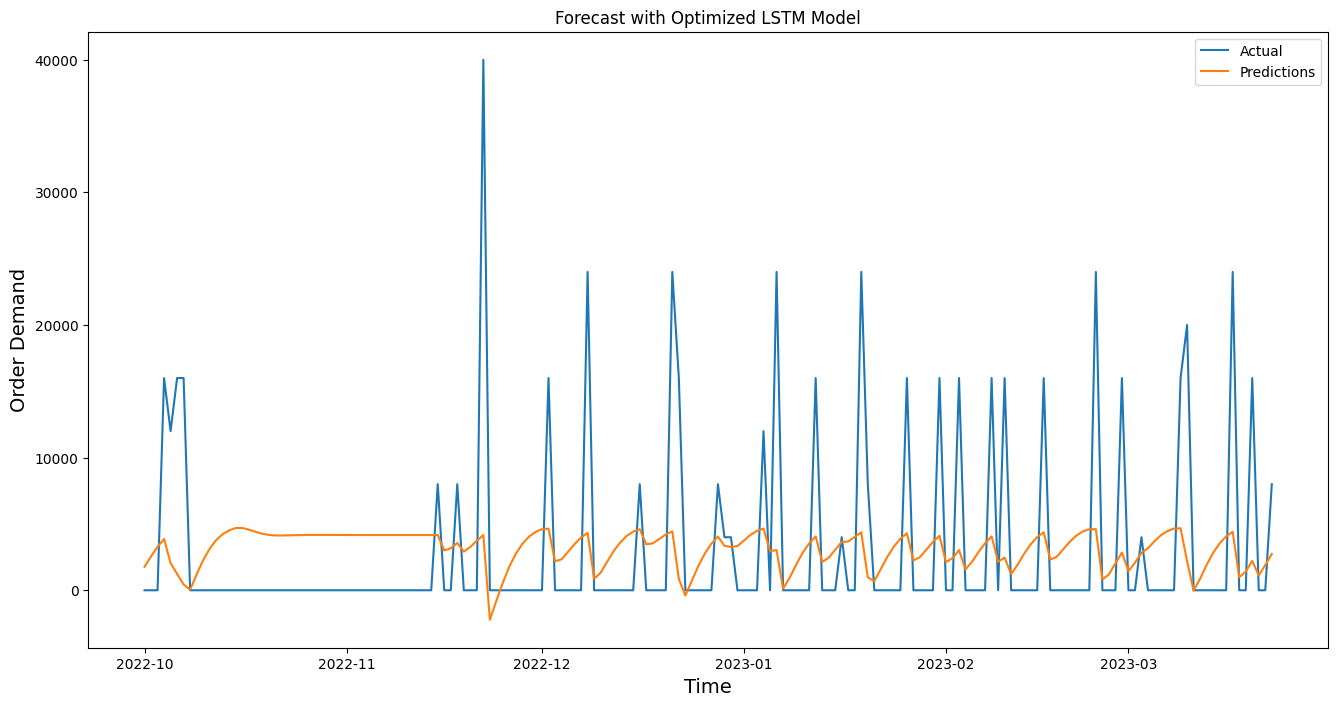

In [25]:
test_data = y_1248[y_1248['거래명세서일']>='2022-10-01']
X_train, y_train, X_val, y_val, X_test, y_test, sc = ts_train_val_test(y_1248,30)
my_LSTM_model, LSTM_prediction, LSTM_prediction_normalized = LSTM_model(X_train, y_train, X_val, y_val, X_test, sc, epochs=20)
actual_pred_plot(test_data,LSTM_prediction)

In [12]:
# Model Metric
def mase(training_series, testing_series, prediction_series):
    n = training_series.shape[0]
    d = np.abs(np.diff(training_series)).sum() / (n-1)
    
    errors = np.abs(testing_series - prediction_series)
    return errors.mean() / d

# Model Metric
def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / (actual+1)))

def nrmse(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred, squared=False)
    target_mean = np.mean(y_true)
    nrmse = mse / target_mean
    return nrmse

In [13]:
def display_metrics(actual, pred):
    #MASE = mase(np.array(train_series), np.array(actual), pred)
    MAPE = mape(actual, pred)
    RMSE = mean_squared_error(actual, pred)**0.5
    MAE = mean_absolute_error(actual,pred)
    NRMSE = nrmse(actual,pred)
    RMSLE = mean_squared_log_error(actual, pred)**0.5
    
    print('------------------ Metric ------------------')
    #print('MASE: \t', MASE)
    print('MAPE: \t', MAPE)
    print('RMSE: \t', RMSE)
    print('MAE: \t',  MAE)
    print('RMSLE: \t', RMSLE)
    print('NRMSE: \t', NRMSE)

In [26]:
orderD = test_data.filter(['출고수량'])
prediction_final = LSTM_prediction
prediction_final = [0 if i<0 else i for i in prediction_final]
orderD["Predictions"] = prediction_final

scaling = MinMaxScaler()

#train_normal = train.filter(['price']).values
#train['price'] = scaling.fit_transform(train_normal)
#test_normal = valid.filter(['price']).values
#valid['price'] = scaling.fit_transform(test_normal)
#pred_normal = valid.filter(['Predictions']).values
#valid['Predictions'] = scaling.fit_transform(pred_normal)

display_metrics(orderD['출고수량'], orderD['Predictions'])

------------------ Metric ------------------
MAPE: 	 [2424.1514]
RMSE: 	 6890.199394564935
MAE: 	 4799.704276227403
RMSLE: 	 7.03541720952007
NRMSE: 	 2.2535614561171027


In [27]:
orderD = test_data.filter(['출고수량'])
prediction_final = LSTM_prediction
prediction_final = [0 if i<0 else i for i in prediction_final]
orderD["Predictions"] = prediction_final

scaling = MinMaxScaler()

test_normal = orderD.filter(['출고수량']).values
orderD['출고수량'] = scaling.fit_transform(test_normal)
pred_normal = orderD.filter(['Predictions']).values
orderD['Predictions'] = scaling.fit_transform(pred_normal)

display_metrics(orderD['출고수량'], orderD['Predictions'])

------------------ Metric ------------------
MAPE: 	 0.5754286601864852
RMSE: 	 0.6565385545076621
MAE: 	 0.5936999683983676
RMSLE: 	 0.47864834618771934
NRMSE: 	 8.58930138979949
